In [1]:
import torch
import time
import numpy as np
from models.networks import NGP
from models.rendering import render
from metrics import psnr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datasets import dataset_dict
from utils import load_ckpt
from train import depth2img

scene = 'Lego'
dataset = dataset_dict['nsvf'](
    f'/home/ubuntu/data/nerf_data/Synthetic_NeRF/{scene}/',
    split='test',
)

Loading 200 test images ...


200it [00:10, 18.84it/s]


In [2]:
model = NGP(scale=1.0).cuda()
load_ckpt(model, f'ckpts/{scene}/epoch=19_slim.ckpt')

In [5]:
psnrs = []; ts = []

for img_idx in tqdm(range(len(dataset))):
    rays = dataset.rays[img_idx][:, :6].cuda()

    t = time.time()
    results = render(model, rays, **{'test_time': True, 'T_threshold': 1e-2})
    torch.cuda.synchronize()
    ts += [time.time()-t]

    if dataset.split != 'test_traj':
        rgb_gt = dataset.rays[img_idx][:, 6:].cuda()
        psnrs += [psnr(results['rgb'], rgb_gt).item()]
if psnrs: print(f'mean PSNR: {np.mean(psnrs):.2f}')
print(f'mean time: {np.mean(ts):.4f} FPS: {1/np.mean(ts):.2f}')

  0%|          | 0/200 [00:00<?, ?it/s]

mean PSNR: 34.94
mean time: 0.0267 FPS: 37.46


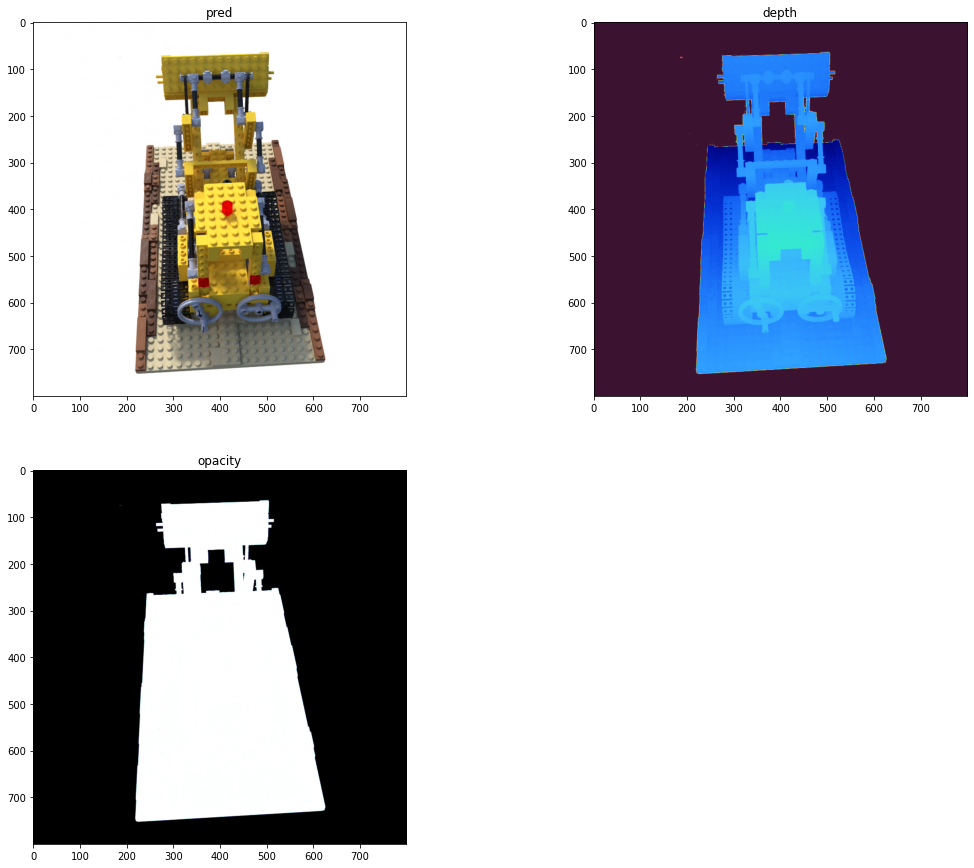

In [5]:
plt.subplots(figsize=(15, 12))
plt.tight_layout()
plt.subplot(221)
plt.title('pred')
pred = results['rgb'].reshape(dataset.img_wh[1], dataset.img_wh[0], 3).cpu().numpy()
plt.imshow(pred)
plt.subplot(222)
plt.title('depth')
depth = results['depth'].reshape(dataset.img_wh[1], dataset.img_wh[0]).cpu().numpy()
depth_ = depth2img(depth)
plt.imshow(depth_)
plt.subplot(223)
plt.title('opacity')
plt.imshow(results['opacity'].reshape(dataset.img_wh[1], dataset.img_wh[0]).cpu().numpy(), 'bone')
plt.show()